In [1]:
# basic packages
import pandas as pd
import os
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
warnings.filterwarnings("ignore")

#Shared/Utility scripts
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from model_scripts import Simple_Eval, dataloader, dataprocessor, xgb_model #had to pip install xgboost
HOME = os.path.expanduser('~')

modelname = 'XGBoost'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script, {device}")

Device: cuda
Device: cuda
XGBoost development script, cuda


In [2]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '300M_Resolution'
DataFrame = 'Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'
remove0swe = True #set to False to use all data, set to True to remove values under a certain threshold
removeswe_thresh = 1 #value in cm to remove ASO obs/rows from. 

alldata = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)

#small adjustments to correct some data
#aspect
alldata['Aspect_Deg'] = alldata['Aspect_Deg']-270
df = alldata[alldata['Aspect_Deg']>= 0]
df['Aspect_Deg'] = abs(df['Aspect_Deg']-90)+270
alldata.update(df)
alldata['Aspect_Deg'] = abs(alldata['Aspect_Deg'])

#Precip - looks like its in inches
alldata['season_precip_cm'] = alldata['season_precip_cm']*2.54

'''for Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs, ASO obs
put SW 2018-04-22, 2018-03-04, San Joaquin, in bad data folder seems too big for peaks
in Southern Rockies 2019-04-07, East River, way too high of values, put in bad data folder'''

Concatenating 13 for the model dataframe development.


  0%|          | 0/13 [00:00<?, ?it/s]

There are 271579 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 97 for the model dataframe development.


  0%|          | 0/97 [00:00<?, ?it/s]

There are 2184173 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 170370 datapoints for model training/testing in the Northwest modeling domain.
There are 2626122 datapoints for model training/testing in the overall modeling domain.


'for Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs, ASO obs\nput SW 2018-04-22, 2018-03-04, San Joaquin, in bad data folder seems too big for peaks\nin Southern Rockies 2019-04-07, East River, way too high of values, put in bad data folder'

Training model to make predictions on 2015-04-06
The provided data contains 2596977 data points, of which 365498 locations/timesteps show no SWE and VIIRS fsca > 20%
271141 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1960287 datapoints for model training/testing.
There are 854880 in the training dataset, removing 1105407 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-11.124 total time=  40.0s
[CV 2/3] END eta=0.1, m

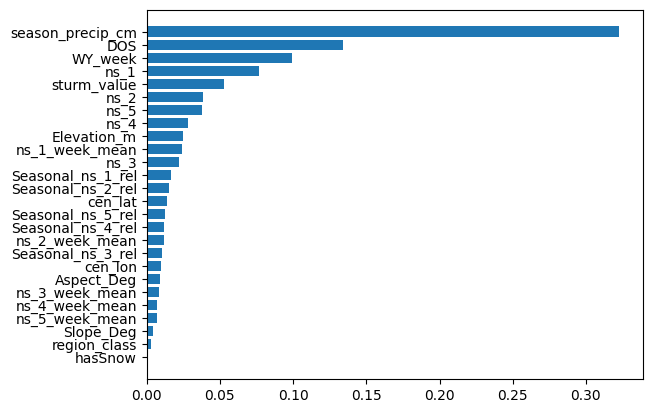

Saving Model
Run is Done!Run Time: 382.9362156391144 seconds 
Model Predictions complete
1000


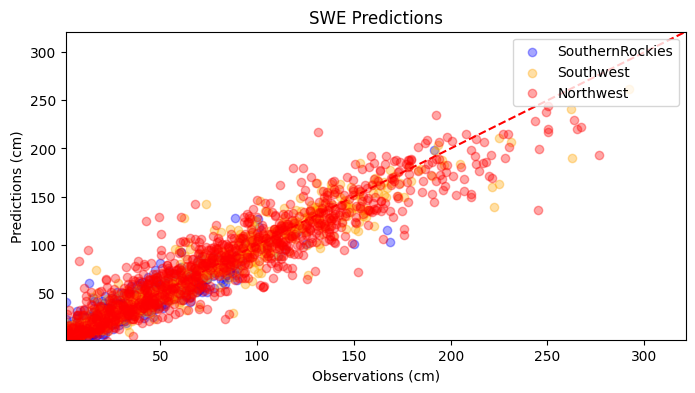

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.93,14.0,31.87,0.24
0,SouthernRockies,0.91,8.0,33.68,-0.07
0,Southwest,0.95,12.0,25.36,0.42
0,Northwest,0.90,21.0,36.58,0.24


Model Predictions complete
Training model to make predictions on 2016-03-29
The provided data contains 2540937 data points, of which 373085 locations/timesteps show no SWE and VIIRS fsca > 20%
257665 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1910136 datapoints for model training/testing.
There are 839069 in the training dataset, removing 1071067 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-11.669 total time=  47

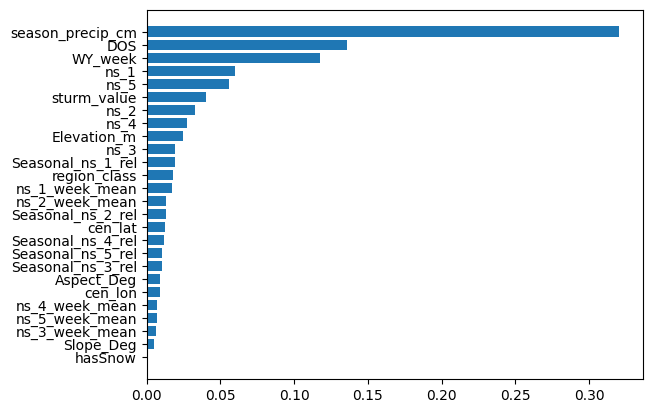

Saving Model
Run is Done!Run Time: 408.41859340667725 seconds 
Model Predictions complete
1000


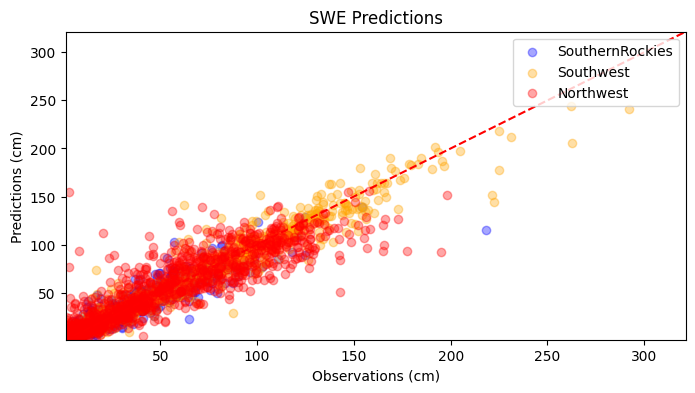

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.92,14.0,38.99,-0.24
0,SouthernRockies,0.90,8.0,30.96,-0.41
0,Southwest,0.95,11.0,25.40,0.28
0,Northwest,0.84,20.0,60.61,-0.69


Model Predictions complete
Training model to make predictions on 2015-04-07
The provided data contains 2578720 data points, of which 369572 locations/timesteps show no SWE and VIIRS fsca > 20%
267239 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1941858 datapoints for model training/testing.
There are 843385 in the training dataset, removing 1098473 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-10.713 total time=  49

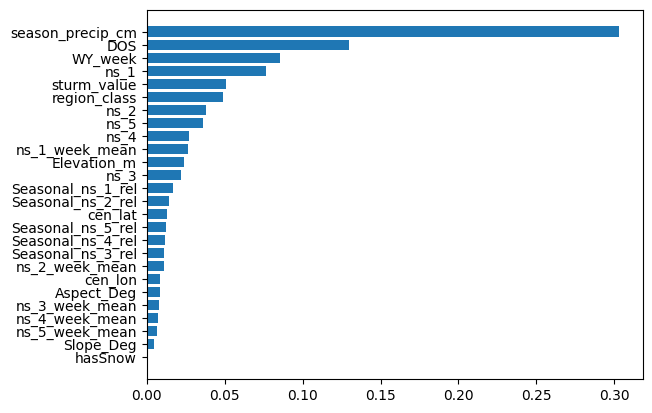

Saving Model
Run is Done!Run Time: 422.48521876335144 seconds 
Model Predictions complete
1000


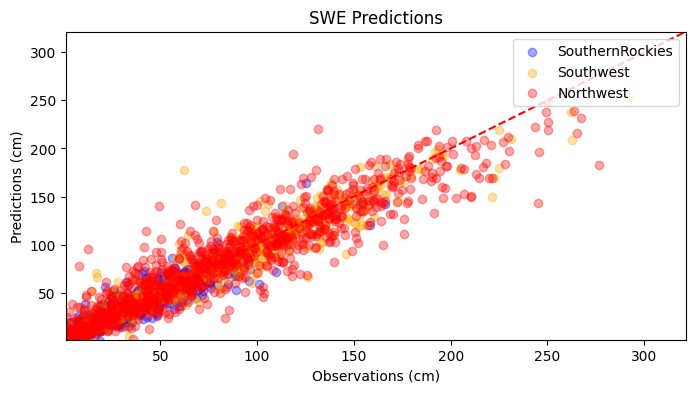

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.94,14.0,30.96,0.04
0,SouthernRockies,0.92,8.0,28.49,0.04
0,Southwest,0.95,12.0,25.62,0.16
0,Northwest,0.90,20.0,38.79,-0.04


Model Predictions complete
Training model to make predictions on 2013-04-29
The provided data contains 2609599 data points, of which 373140 locations/timesteps show no SWE and VIIRS fsca > 20%
269821 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1966587 datapoints for model training/testing.
There are 850708 in the training dataset, removing 1115879 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-11.614 total time=  46

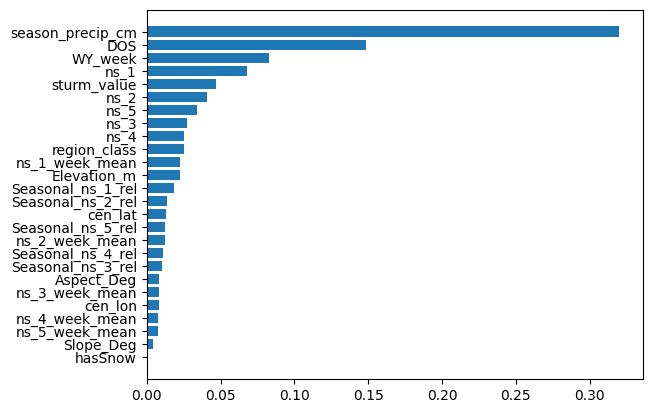

Saving Model
Run is Done!Run Time: 415.45378971099854 seconds 
Model Predictions complete
1000


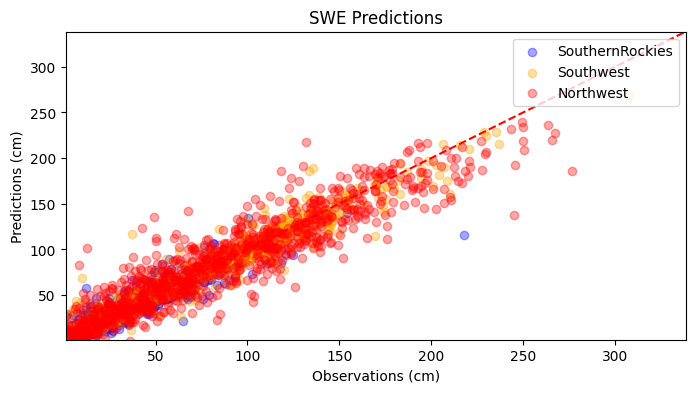

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.94,14.0,32.88,-0.20
0,SouthernRockies,0.91,8.0,33.13,-0.40
0,Southwest,0.96,10.0,26.98,-0.02
0,Northwest,0.90,21.0,38.52,-0.26


Model Predictions complete
Training model to make predictions on 2018-03-30
The provided data contains 2616744 data points, of which 373066 locations/timesteps show no SWE and VIIRS fsca > 20%
272552 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1971075 datapoints for model training/testing.
There are 852106 in the training dataset, removing 1118969 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-10.962 total time=  43

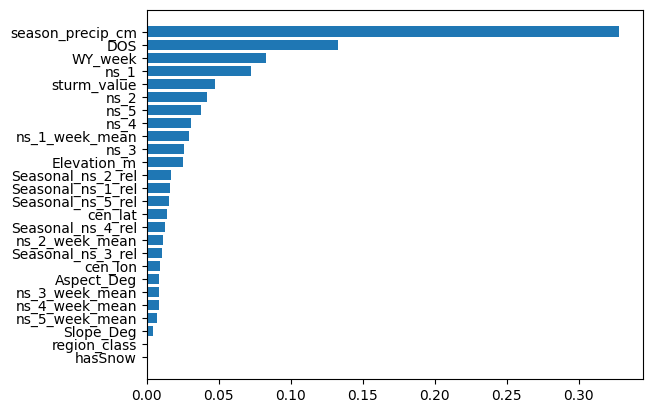

Saving Model
Run is Done!Run Time: 414.2524302005768 seconds 
Model Predictions complete
1000


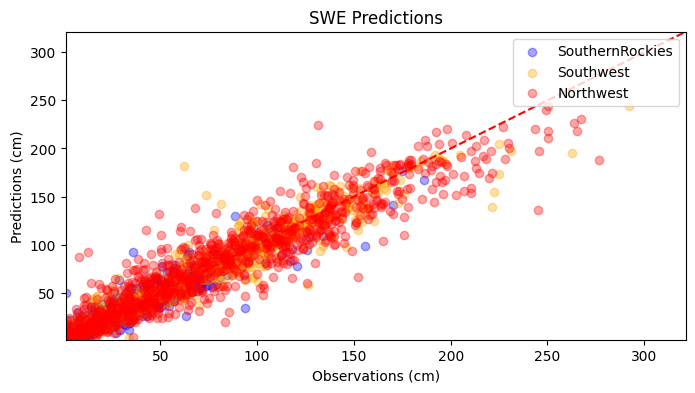

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.94,15.0,33.36,0.11
0,SouthernRockies,0.92,8.0,35.31,0.54
0,Southwest,0.95,12.0,26.04,0.06
0,Northwest,0.90,21.0,38.73,-0.02


Model Predictions complete
Training model to make predictions on 2018-03-31
The provided data contains 2602331 data points, of which 368639 locations/timesteps show no SWE and VIIRS fsca > 20%
271571 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1962070 datapoints for model training/testing.
There are 846691 in the training dataset, removing 1115379 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-10.788 total time=  44

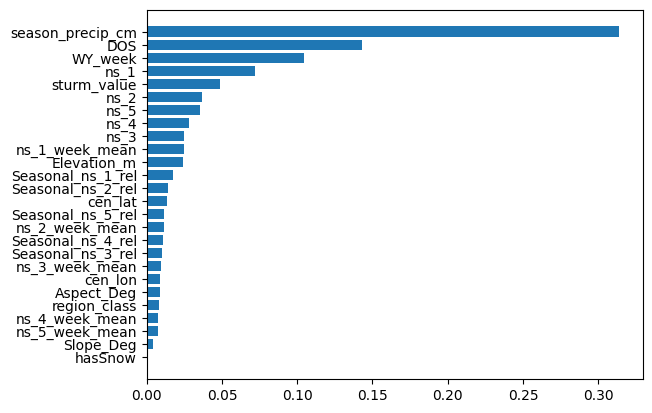

Saving Model
Run is Done!Run Time: 420.1817305088043 seconds 
Model Predictions complete
1000


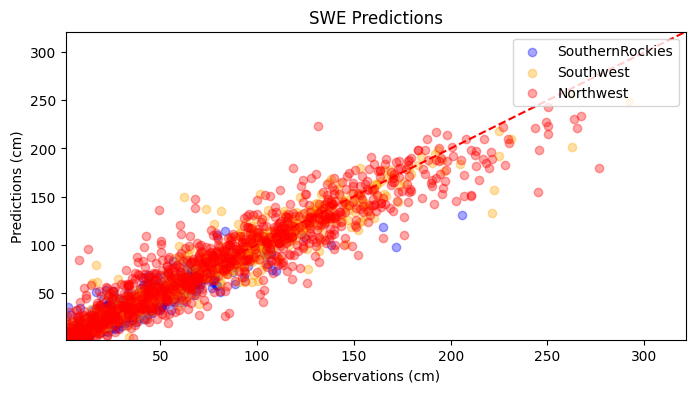

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.94,14.0,32.19,0.19
0,SouthernRockies,0.87,8.0,31.57,1.89
0,Southwest,0.95,11.0,25.72,0.15
0,Northwest,0.90,21.0,39.29,-0.40


Model Predictions complete
Training model to make predictions on 2015-04-12
The provided data contains 2578152 data points, of which 363216 locations/timesteps show no SWE and VIIRS fsca > 20%
269075 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1945810 datapoints for model training/testing.
There are 852998 in the training dataset, removing 1092812 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-11.716 total time=  44

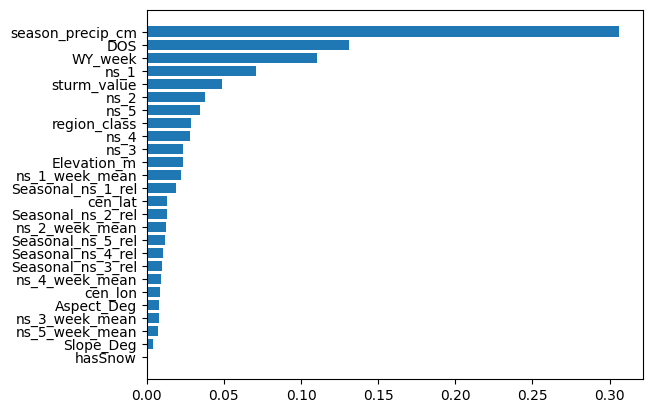

Saving Model
Run is Done!Run Time: 405.3323805332184 seconds 
Model Predictions complete
1000


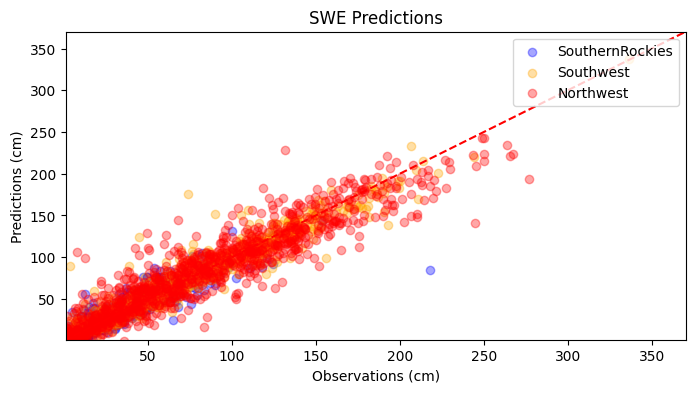

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.94,14.0,32.74,-0.39
0,SouthernRockies,0.90,9.0,32.32,-0.79
0,Southwest,0.96,11.0,27.74,-0.63
0,Northwest,0.90,21.0,38.17,-0.09


Model Predictions complete
Training model to make predictions on 2018-04-22
The provided data contains 2626122 data points, of which 373141 locations/timesteps show no SWE and VIIRS fsca > 20%
272684 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
20 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
51 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 1980246 datapoints for model training/testing.
There are 861220 in the training dataset, removing 1119026 zero values in the ASO dataset, VIIRS fSCA will capture these.
Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=3500;, score=-11.427 total time=  44

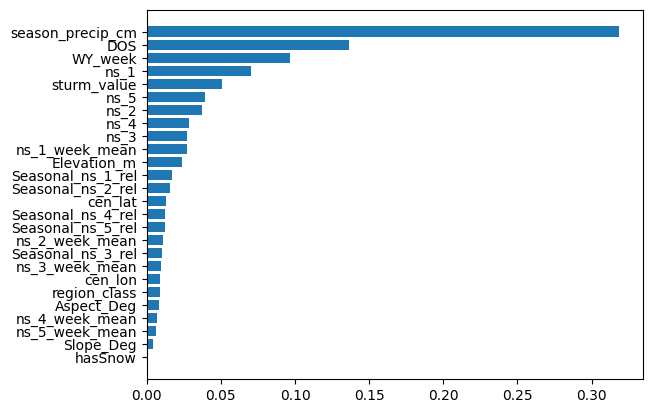

Saving Model
Run is Done!Run Time: 398.0344364643097 seconds 
Model Predictions complete
1000


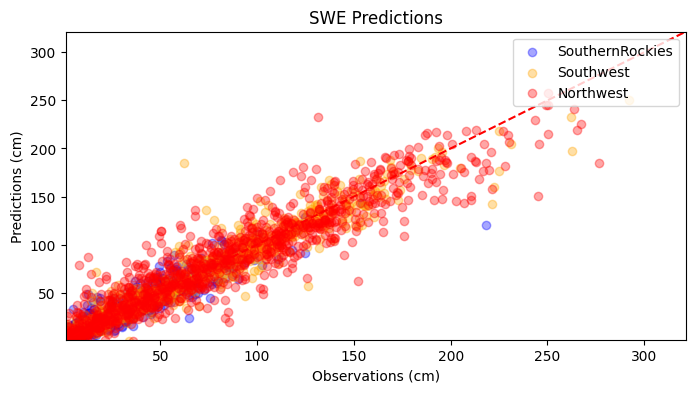

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.94,14.0,31.72,-0.25
0,SouthernRockies,0.91,8.0,32.67,-0.67
0,Southwest,0.95,12.0,25.39,0.36
0,Northwest,0.91,21.0,37.10,-0.52


Model Predictions complete


In [4]:
# Pulling out 3-29-2019 in Southwest
#date = '2019-03-29' # Merced
#date = '2019-04-19' # Blue
#dates = '2019-04-08' # Taylor
#One prediction in each watershed
dates = [#'2016-02-08', #Olympia
         '2015-04-06', #Conejos - only one obs, likely poor Never seen prediction location
         #'2013-04-03', # Tuolomne
         '2016-03-29', #Olympic
         '2015-04-07', #upper Rio Grande
         '2013-04-29', #Tuolumne
         #'2015-06-02', #Upper Rio Grande
        # '2013-05-03', #Tuolumne
         #'2016-04-03', #Upper Rio Grande
         #'2013-05-25',#Tuolumne
         #'2016-04-04', #East
         #'2013-06-01', #Tuolumne
         '2018-03-30', #Taylor
         '2018-03-31', #East
         #'2018-05-24',#East
        #'2019-04-08', #Taylor
       #  '2019-04-19', #Blue - only one obs?. two?, likely poor Never seen prediction location
         #'2019-06-09', #Taylor
         #'2019-06-10', #East
        # '2014-04-29', #Merced
        #'2019-03-29', # Merced
          '2015-04-12', #Kings
          '2018-04-22' #San Joaquin
         ]



#train each model and predict
for date in dates:

    print(f"Training model to make predictions on {date}")

    TestArea = alldata[alldata['Date'] == date]
    TestArea.reset_index(inplace=True, drop=True)

    #remove Test area data from training/testing dataset
    df = pd.concat([alldata, TestArea]).drop_duplicates(keep=False)

    #clean the data
    df = dataprocessor.data_clean(df, regionlist)
    df.head()

    #temporary for seasonality relationship
    df.fillna(1, inplace = True)

    #convert dates to datetime format
    df.Date = pd.to_datetime(df.Date)

    input_columns = [
                'cen_lat',	
                'cen_lon',	
                'Elevation_m',	
                'Slope_Deg',	
                'Aspect_Deg',	
                'ns_1',	
                'ns_2',	
                'ns_3',	
                'ns_4',	
                'ns_5',	
                #'ns_6',	
                #'VIIRS_SCA', 
                'hasSnow',
                'season_precip_cm',
                'region_class',
                'DOS', 
                'WY_week',
                'ns_1_week_mean', 
                'ns_2_week_mean', 
                'ns_3_week_mean', 
                'ns_4_week_mean',
                'ns_5_week_mean', 
                #'ns_6_week_mean', 
                'Seasonal_ns_1_rel',
                'Seasonal_ns_2_rel',
                'Seasonal_ns_3_rel', 
                'Seasonal_ns_4_rel',
                'Seasonal_ns_5_rel', 
                #'Seasonal_ns_6_rel',
                'sturm_value',
            # 'vegetation_value'
    ]



    years = False
    splitratio = 0.1
    test_years = [2019]
    target = 'swe_cm'
    remove0swe = True #set to False to use all data, set to True to remove values under a certain threshold
    removeswe_thresh = 1 #value in cm to remove ASO obs/rows from. 
    #remove the large amounts of zero values
    df = dataloader.remove0swe(df, remove0swe, removeswe_thresh)


    #fit a scaler,save, and scale the training data
    x_train, y_train, x_test, y_test = dataprocessor.xgb_processor(
                                                        regionlist,
                                                        df, 
                                                        years, 
                                                        splitratio,
                                                        test_years, 
                                                        target, 
                                                        input_columns, 
                                                        model_path, 
                                                        scalertype = 'MinMax'
                                                        )
    #Train model
    tries = 1 #what is tries?
    hyperparameters = {
        'max_depth': [8], #range (10, 21, 5),
        'n_estimators': [3500], #range(500, 1600, 500),
        'eta': [0.1,]
    }
    perc_data = 0.25 # percent of training data used to identify optimal hyperparameters

    Use_fSCA_Threshold = True

    xgb_model.XGB_Train(model_path, 
                        input_columns, 
                        x_train, 
                        y_train, 
                        tries, 
                        hyperparameters,
                        perc_data)

    #Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
    PredsDF = pd.DataFrame()
    PredsDF = xgb_model.XGB_Predict(
                        model_path, 
                        modelname, 
                        x_test,
                        y_test,
                        Use_fSCA_Threshold
                        )
    #Take a sample to determine model skill - Take 1000 from each modeling domain
    n_samples = 1000
    SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)


    savfig = True
    figname = f"Model-Testing-Split-Performance-HOO-{date}"

    #Evaluate model performance of the different models
    prediction_columns = [f"{modelname}_swe_cm"]
    Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                    SampleDF,
                                    prediction_columns, 
                                    modelname, 
                                    savfig, 
                                    figname,
                                    plots = False, 
                                    keystats = False        
                                    )

    #Prep prediction data
    y_test_Area = pd.DataFrame(TestArea['swe_cm'])
    dropcols = ['cell_id',	'Date', 'swe_cm', 'region']
    x_test_Area = TestArea.drop(columns=dropcols)
    x_test_Area = x_test_Area[input_columns]

    #make a prediction
    holdoutdate = xgb_model.XGB_Predict(
                        model_path, 
                        modelname, 
                        x_test_Area,
                        y_test_Area,
                        Use_fSCA_Threshold
                        )
    #Add geospatial information to prediction DF
    EvalDF = pd.concat([TestArea, holdoutdate], axis=1)
    #EvalDF.drop(['index'], axis=1, inplace=True)
    EvalDF = EvalDF.loc[:,~EvalDF.columns.duplicated()].copy()

    EvalDF.head(5)

    Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
    if not os.path.exists(Ppath):
        os.makedirs(Ppath, exist_ok=True)


    #save the model predictions
    table = pa.Table.from_pandas(EvalDF)
    # Parquet with Brotli compression
    pq.write_table(table, f"{Ppath}/0SWEthresh_All_Feats_HoldOut_{date}.parquet", compression='BROTLI')